In [108]:
import torch 
import gpytorch
import config_safeopt as cfg
from GPTrainer import GPTrainer
import math
import gp_config as gp_cfg    
from beta import beta_srinivas09 as beta
train_x = cfg.INITIAL_X
train_y = cfg.INITIAL_Y
%load_ext autoreload 
%autoreload 2
# gp_trainer = GPTrainer(gp_cfg, train_x, train_y)

C_lower = torch.full_like(cfg.DOMAIN.flatten(), -1e9)
C_upper = torch.full_like(cfg.DOMAIN.flatten(), 1e9)
C_lower[cfg.INITIAL_SAFE_INDICES] = cfg.SAFETY_THRESHOLD
    
S_mask = torch.zeros(cfg.N_POINTS, dtype=torch.bool)
S_mask[cfg.INITIAL_SAFE_INDICES] = True
    
# Pre-compute pairwise distances for the discrete domain D
distance_matrix = torch.cdist(cfg.DOMAIN, cfg.DOMAIN) 

gp_trainer = GPTrainer(gp_cfg, train_x, train_y)
gp_trainer.train()
train_x = [] 
train_y = []           


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Iter 1/25 - Loss: -0.023   noise: 0.000   Length_scale: 0.693   output_scale: 0.693
Iter 2/25 - Loss: -0.320   noise: 0.000   Length_scale: 0.598   output_scale: 0.798
Iter 3/25 - Loss: -0.611   noise: 0.000   Length_scale: 0.513   output_scale: 0.913
Iter 4/25 - Loss: -0.856   noise: 0.000   Length_scale: 0.438   output_scale: 1.036
Iter 5/25 - Loss: -1.035   noise: 0.000   Length_scale: 0.372   output_scale: 1.163
Iter 6/25 - Loss: -1.147   noise: 0.000   Length_scale: 0.316   output_scale: 1.288
Iter 7/25 - Loss: -1.207   noise: 0.000   Length_scale: 0.270   output_scale: 1.406
Iter 8/25 - Loss: -1.227   noise: 0.000   Length_scale: 0.233   output_scale: 1.510
Iter 9/25 - Loss: -1.225   noise: 0.000   Length_scale: 0.203   output_scale: 1.598
Iter 10/25 - Loss: -1.210   noise: 0.000   Length_scale: 0.180   output_scale: 1.667
Iter 11/25 - Loss: -1.191   noise: 0.000   Length_scale: 0.161   output

In [109]:
i = 1

In [114]:

# gp_trainer.train_s(train_x, train_y)
print("l_scale --" ,gp_trainer.model.covar_module.base_kernel.lengthscale.item())
print("output scale  -- " ,gp_trainer.model.covar_module.outputscale)

mean, std_dev = gp_trainer.get_posterier(cfg.DOMAIN)

beta_t_sqr = math.sqrt(beta(i,cfg.N_POINTS,gp_trainer.model.likelihood.noise.item(),gp_trainer.model.covar_module.outputscale))

Q_lower = mean - beta_t_sqr * std_dev
Q_upper = mean + beta_t_sqr * std_dev
Q_lower = mean - cfg.BETA * std_dev
Q_upper = mean + cfg.BETA * std_dev


C_lower = torch.max(C_lower, Q_lower) 
C_upper = torch.min(C_upper,Q_upper)
C_lower = Q_lower
C_upper = Q_upper

S_prev_indices = torch.where(S_mask)[0]
new_S_mask = S_mask.clone()
# dire 
for s_idx in S_prev_indices:
    # set of indicies for all points that are lipschitz safe relative to x[s_idx]
    lipschitz_safe = C_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx] >= cfg.SAFETY_THRESHOLD
    new_S_mask = torch.logical_or(new_S_mask, lipschitz_safe)
    safety_val  =  C_lower[s_idx] - cfg.LIPSCHITZ_CONSTANT * distance_matrix[s_idx]
    # dire = torch.maximum(dire, safety_val)
S_mask = new_S_mask

# safe_lis = dire.detach().cpu.numpy()

if not torch.any(S_mask):
    print(f"Iteration {i+1}: Safe set is empty. Stopping.")
    

wt_D = C_upper - C_lower
wt_S = torch.full_like(wt_D, -1e9)
wt_S[S_mask] = wt_D[S_mask]

xt = cfg.DOMAIN[torch.argmax(wt_S)]
yt = cfg.ground_truth(xt) + torch.randn(1) * 0.01 # 

# print (train_y.shape, yt.unsqueeze(0).shape , yt.shape)
# print(train_x.shape, xt.unsqueeze(0).shape , train_y.shape, yt.shape)
if len(train_x) == 0 :
    train_x = xt.unsqueeze(0)
    train_y = yt 
else :
    train_x = torch.cat([train_x, xt.unsqueeze(0)])
    train_y = torch.cat([train_y, yt])

print(f"Final train set size : {len(train_x)} \n Final safe set = {torch.where(S_mask)[0].tolist()}")

gp_trainer = GPTrainer(gp_cfg, train_x, train_y)
gp_trainer.model.covar_module.base_kernel.lengthscale = 0.1
# gp_trainer.train()
i+=1

l_scale -- 0.10000000149011612
output scale  --  tensor(0.6931, grad_fn=<SoftplusBackward0>)
Final train set size : 4 
 Final safe set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84]


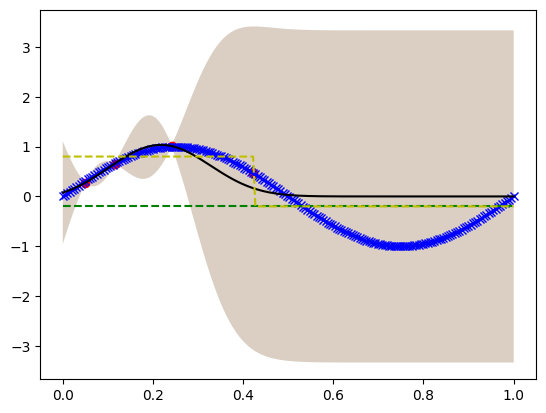

In [115]:
import matplotlib.pyplot as plt

plt.plot(train_x.numpy(), train_y.numpy(), 'ro', label='Training Data')
plt.plot(cfg.DOMAIN.numpy(), cfg.ground_truth(cfg.DOMAIN).numpy(), 'bx--', label='Ground Truth')
plt.plot(cfg.DOMAIN.numpy(), mean.numpy(), 'k-', label='GP Mean')
plt.plot(cfg.DOMAIN.numpy(), cfg.SAFETY_THRESHOLD * torch.ones_like(cfg.DOMAIN).numpy(), 'g--', label='Safety Threshold')
plt.plot(cfg.DOMAIN.numpy(),S_mask.float()-0.2, 'y--')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), C_lower.numpy(), C_upper.numpy(), alpha=0.2, label='C Bounds')
plt.fill_between(cfg.DOMAIN.numpy().flatten(), Q_lower.numpy(), Q_upper.numpy(), alpha=0.2, label='C Bounds')